# Preliminary Test Analysis

## 1. Data Loading and Preprocessing

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

RUNS_FILES = [
    # "../results/runs/risk_averse_0_00.csv",
    # "../results/runs/risk_averse_0_25.csv",
    # "../results/runs/risk_averse_0_50.csv",
    # "../results/runs/risk_averse_1_00.csv",
    # "../results/runs/risk_averse_2_00.csv",
    # "../results/runs/risk_averse_5_00.csv",
    "../results/runs/greedy.csv",
    "../results/runs/prob_greedy_0.csv",
    "../results/runs/prob_greedy_1.csv",
    "../results/runs/prob_greedy_2.csv",
    "../results/runs/prob_greedy_3.csv",
    "../results/runs/prob_greedy_5.csv",
    # "../results/runs/standard_rollout_D1.csv",
    # "../results/runs/standard_rollout_D2.csv",
    # "../results/runs/standard_rollout_D3.csv",
]

# Add source_file column to track which file each row came from
frames_with_source = []
for f in RUNS_FILES:
    temp_df = pd.read_csv(f)
    temp_df["source_file"] = f
    frames_with_source.append(temp_df)

df = pd.concat(frames_with_source, ignore_index=True, sort=False)

# Rename strategies based on their source file
for file in RUNS_FILES:
    file_base = file.split("/")[-1].split(".")[0]
    df.loc[df["source_file"] == file, "strategy"] = file_base

# types & helpers
df["alpha"] = pd.to_numeric(df["alpha"], errors="coerce")
df["lambda"] = pd.to_numeric(df["lambda"], errors="coerce")
df["deterministic"] = (df["kernel"] == "deterministic").astype(int)
df["solved"] = df["solved"].astype(int)
df["presses_used"] = df["presses_used"].astype(int)
df["det_solvable"] = df["det_solvable"].astype(int)
df["board_id"] = df["board_id"].astype(int)

print(df.head())
print(df["strategy"].value_counts())

   n kernel  alpha  lambda strategy  seed  board_id  initial_on  det_solvable  \
0  5    exp   0.05     0.5   greedy    42         0           3             0   
1  5    exp   0.05     0.5   greedy    42         1           3             0   
2  5    exp   0.05     0.5   greedy    42         2          10             1   
3  5    exp   0.05     0.5   greedy    42         3          10             0   
4  5    exp   0.05     0.5   greedy    42         4          16             0   

   solved  presses_used  time_ms  time_per_action_ms  rescued  broken  \
0       1             3   0.1741            0.058033        1       0   
1       1             3   0.0867            0.028900        1       0   
2       1            15   0.2621            0.017473        0       0   
3       1            12   0.2059            0.017158        1       0   
4       1            18   0.3079            0.017106        1       0   

                  source_file  deterministic  
0  ../results/runs/greedy.c

## 2. Statistical Helper Functions

In [33]:
from typing import Tuple
import numpy as np
from scipy.stats import binomtest, bootstrap

# Helper wrappers using SciPy


def wilson_ci(
    k: int, n: int, alpha: float = 0.05
) -> Tuple[float, float, float]:
    """Return (p_hat, lower, upper) Wilson-like interval using binomtest (Clopper-Pearson).
    SciPy doesn't expose Wilson directly; Clopper-Pearson is conservative but standard.
    If Wilson specifically is required, we could re-implement or use statsmodels.
    """
    if n == 0:
        return np.nan, np.nan, np.nan
    res = binomtest(k, n)
    lo, hi = res.proportion_ci(confidence_level=1 - alpha, method="exact")
    p = k / n
    return p, lo, hi


def bootstrap_mean(
    x, B: int = 2000, confidence_level: float = 0.95, seed: int = 0
):
    """Return (mean, lower, upper) bootstrap CI for the mean using SciPy bootstrap.
    SciPy's bootstrap returns confidence interval; we also return the sample mean.
    """
    x = np.asarray(x)
    if x.size == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    res = bootstrap(
        (x,),
        np.mean,
        vectorized=False,
        n_resamples=B,
        rng=rng,
        confidence_level=confidence_level,
    )
    mu = float(np.mean(x))
    lo, hi = map(float, res.confidence_interval)
    return mu, lo, hi

## 3. Solve Rate Analysis

In [34]:
# Remove some strategies for clarity
df = df[~df["strategy"].isin(["rollout"])]

# Check which time columns exist in the dataframe
agg_dict = {
    "solve_frac": ("solved", "mean"),
    "mean_presses": ("presses_used", "mean"),
}

# Add time columns only if they exist
if "time_ms" in df.columns:
    agg_dict["mean_time_ms"] = ("time_ms", "mean")
if "time_per_action_ms" in df.columns:
    agg_dict["mean_time_per_action_ms"] = ("time_per_action_ms", "mean")

board_strat = df.groupby(
    ["board_id", "strategy", "kernel"], as_index=False
).agg(**agg_dict)

board_strat.head()

,board_id,strategy,kernel,solve_frac,mean_presses,mean_time_ms,mean_time_per_action_ms
0,0,greedy,exp,0.666667,198.966667,3.028040,0.024481
1,0,prob_greedy_0,exp,0.433333,297.600000,266.799797,0.896117
2,0,prob_greedy_1,exp,0.666667,197.366667,450.663760,2.242603
3,0,prob_greedy_2,exp,0.600000,244.600000,546.147943,2.224445
4,0,prob_greedy_3,exp,0.666667,192.300000,435.967173,2.296527


In [35]:
rows = []
for (kernel, strat), g in board_strat.groupby(
    ["kernel", "strategy"], sort=True
):
    strat_data = df[df["strategy"] == strat]

    board_values = strat_data.groupby("board_id")["solved"].mean()
    n_boards = len(board_values)

    mean = board_values.mean()

    sem = stats.sem(board_values)
    t_crit = stats.t.ppf(0.975, df=n_boards - 1)
    lo, hi = mean - t_crit * sem, mean + t_crit * sem
    rows.append(
        {
            "strategy": strat,
            "kernel": kernel,
            "n_boards": n_boards,
            "solve_rate": mean,
            "ci_low": lo,
            "ci_high": hi,
        }
    )

solve_ci = pd.DataFrame(rows).sort_values("solve_rate", ascending=False)
# Output the final table without indices
solve_ci

,strategy,kernel,n_boards,solve_rate,ci_low,ci_high
0,greedy,exp,100,0.663000,0.657213,0.668787
4,prob_greedy_3,exp,100,0.512667,0.494614,0.530720
2,prob_greedy_1,exp,100,0.507333,0.489310,0.525357
3,prob_greedy_2,exp,100,0.489333,0.473606,0.505061
5,prob_greedy_5,exp,100,0.483667,0.474577,0.492757
1,prob_greedy_0,exp,100,0.421667,0.412631,0.430702


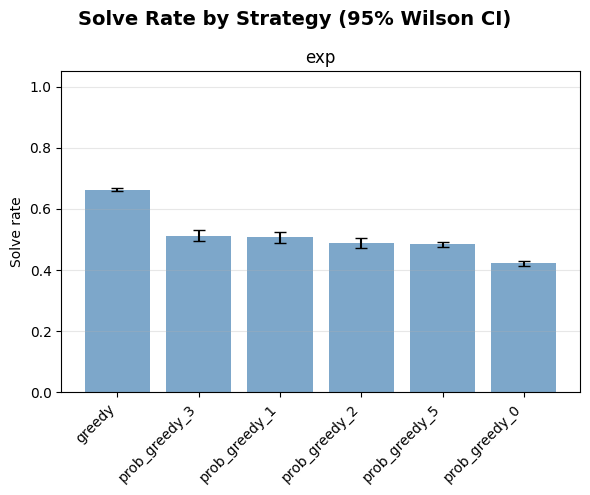

In [36]:
# Create subfigures for all kernels in one figure
kernels = solve_ci["kernel"].unique()
fig, axes = plt.subplots(1, len(kernels), figsize=(6 * len(kernels), 5))
if len(kernels) == 1:
    axes = [axes]

for idx, kernel in enumerate(kernels):
    g = solve_ci[solve_ci["kernel"] == kernel].sort_values(
        "solve_rate", ascending=False
    )
    x = np.arange(len(g))
    heights = g["solve_rate"]
    lo = g["ci_low"]
    hi = g["ci_high"]
    yerr = np.vstack([heights - lo, hi - heights])

    axes[idx].bar(x, heights, color="steelblue", alpha=0.7)
    axes[idx].errorbar(
        x, heights, yerr=yerr, fmt="none", capsize=4, color="black"
    )
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(
        g["strategy"].astype(str).tolist(), rotation=45, ha="right"
    )
    axes[idx].set_ylim(0, 1.05)
    axes[idx].set_ylabel("Solve rate")
    axes[idx].set_title(f"{kernel}")
    axes[idx].grid(axis="y", alpha=0.3)

fig.suptitle(
    "Solve Rate by Strategy (95% Wilson CI)", fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()

## 4. Solve Rate across noise parameters

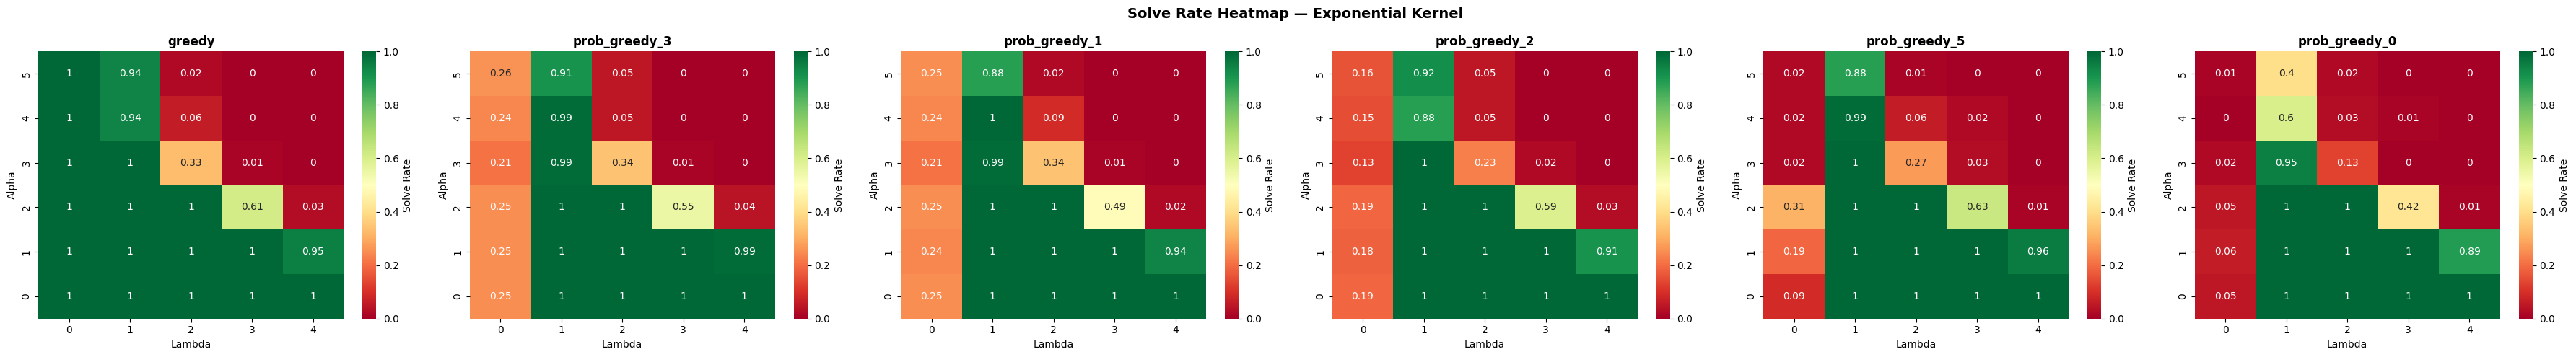

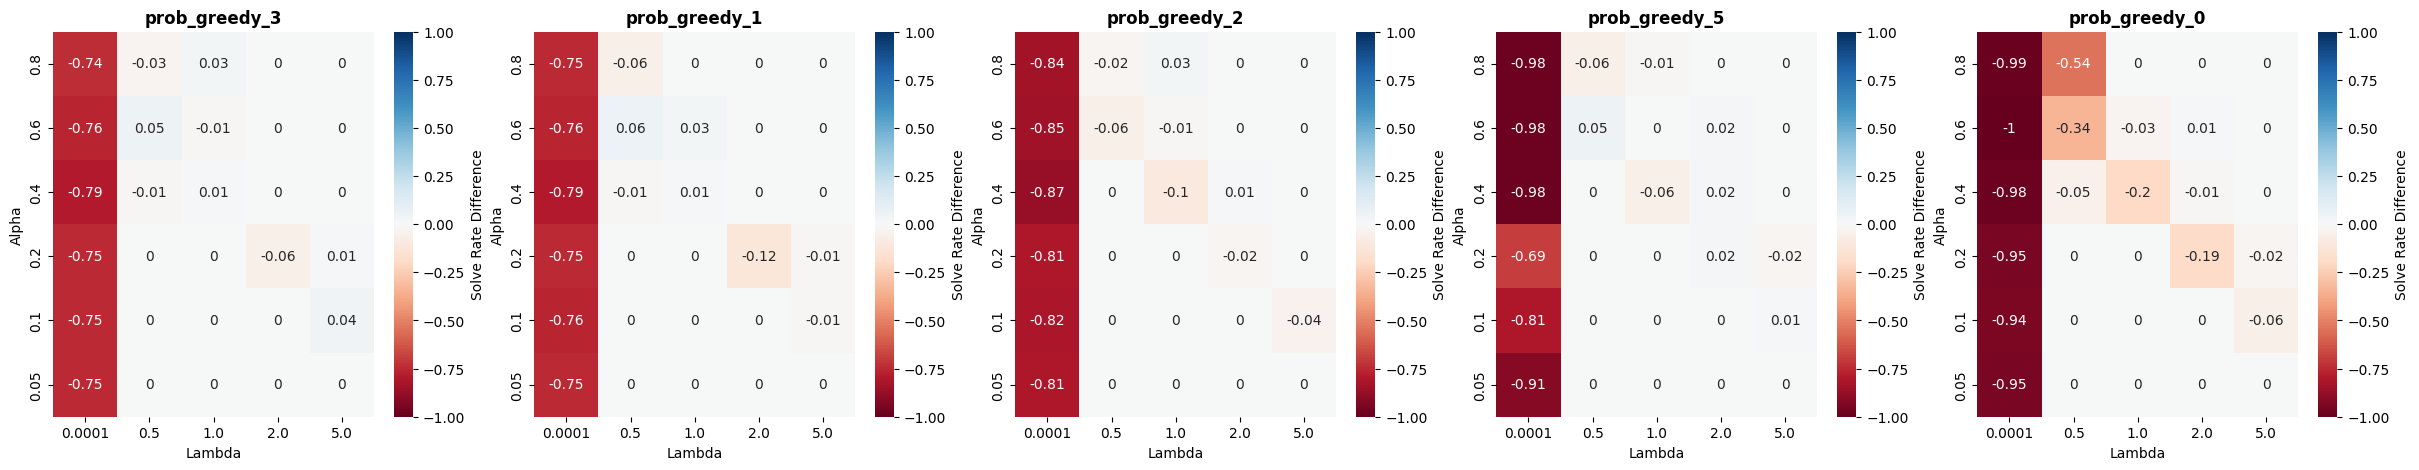

In [37]:
# Solve rate heatmaps for exponential kernel
exp_only = df[df["kernel"] == "exp"].copy()
rows = []
for (strategy, a, l), g in exp_only.groupby(["strategy", "alpha", "lambda"]):
    p, lo, hi = wilson_ci(g["solved"].sum(), len(g))
    rows.append(
        {"strategy": strategy, "alpha": a, "lambda": l, "solve_rate": p}
    )
grid = pd.DataFrame(rows)

alphas = np.sort(grid["alpha"].unique())
lambdas = np.sort(grid["lambda"].unique())
strategies = sorted(
    grid["strategy"].unique(),
    key=lambda s: grid[grid["strategy"] == s]["solve_rate"].mean(),
    reverse=True,
)

# Create subfigures for all strategies
n_strategies = len(strategies)
fig, axes = plt.subplots(1, n_strategies, figsize=(6 * n_strategies, 5))
if n_strategies == 1:
    axes = [axes]

for idx, strategy in enumerate(strategies):
    gs = grid[grid["strategy"] == strategy]
    M = np.full((len(alphas), len(lambdas)), np.nan)
    for i, a in enumerate(alphas):
        for j, lam in enumerate(lambdas):
            val = gs[(gs["alpha"] == a) & (gs["lambda"] == lam)]["solve_rate"]
            if len(val):
                M[i, j] = val.iloc[0]

    sns.heatmap(
        M,
        ax=axes[idx],
        cmap="RdYlGn",
        vmin=0,
        vmax=1,
        cbar_kws={"label": "Solve Rate"},
        annot=True,
    )
    axes[idx].invert_yaxis()
    axes[idx].set_title(
        f"{strategy}",
        fontsize=12,
        fontweight="bold",
    )
    axes[idx].set_xlabel("Lambda")
    axes[idx].set_ylabel("Alpha")

fig.suptitle(
    "Solve Rate Heatmap — Exponential Kernel", fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()

# Plot a difference heatmap between the greedy baseline and other strategies
baseline_strategy = "greedy"

# Filter out baseline strategy first
comparison_strategies = [s for s in strategies if s != baseline_strategy]

# Calculate grid dimensions
n_strategies = len(comparison_strategies)
n_cols = 3  # Use 3 columns for better layout
n_rows = (n_strategies + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(1, n_strategies, figsize=(6 * n_strategies, 5))
if n_strategies == 1:
    axes = [axes]

for idx, strategy in enumerate(comparison_strategies):
    strategy_df = df[df["strategy"].isin([baseline_strategy, strategy])]

    pivot_baseline = strategy_df[
        strategy_df["strategy"] == baseline_strategy
    ].pivot_table(
        index="alpha",
        columns="lambda",
        values="solved",
        aggfunc="mean",
    )

    pivot_strategy = strategy_df[
        strategy_df["strategy"] == strategy
    ].pivot_table(
        index="alpha",
        columns="lambda",
        values="solved",
        aggfunc="mean",
    )

    # Calculate difference
    pivot_diff = pivot_strategy - pivot_baseline
    sns.heatmap(
        pivot_diff,
        ax=axes[idx],
        cmap="RdBu",
        center=0,
        vmin=-1,
        vmax=1,
        cbar_kws={"label": "Solve Rate Difference"},
        annot=True,
    )
    axes[idx].invert_yaxis()
    axes[idx].set_title(
        f"{strategy}",
        fontsize=12,
        fontweight="bold",
    )
    axes[idx].set_xlabel("Lambda")
    axes[idx].set_ylabel("Alpha")

    # Add colorbar to each subplot
    # plt.colorbar(im, ax=axes[idx], label="solve rate", fraction=0.046, pad=0.04)

# Hide any unused subplots
for idx in range(len(comparison_strategies), len(axes)):
    axes[idx].set_visible(False)
plt.show()

## 5. Efficiency Analysis (Presses Used)

In [38]:
# Mean presses by kernel and strategy - averaged across parameter settings
rows = []
for (kernel, strategy), g in df[df["solved"] == 1].groupby(
    ["kernel", "strategy"]
):
    # For each board, compute mean presses across all parameter settings where it was solved
    board_mean_presses = g.groupby("board_id")["presses_used"].mean()

    mu = board_mean_presses.mean()
    std = board_mean_presses.std()
    rows.append(
        {
            "kernel": kernel,
            "strategy": strategy,
            "mean_presses": mu,
            "std": std,
            "n_boards": len(board_mean_presses),
            "n_runs": len(g),
        }
    )

press = pd.DataFrame(rows).sort_values(["kernel", "mean_presses"])
press

,kernel,strategy,mean_presses,std,n_boards,n_runs
0,exp,greedy,61.599591,16.148480,100,1989
2,exp,prob_greedy_1,66.213557,24.579475,100,1522
4,exp,prob_greedy_3,68.614685,23.987840,100,1538
3,exp,prob_greedy_2,69.179649,22.444140,100,1468
1,exp,prob_greedy_0,74.288654,26.686561,100,1265
5,exp,prob_greedy_5,75.468614,23.540944,100,1451


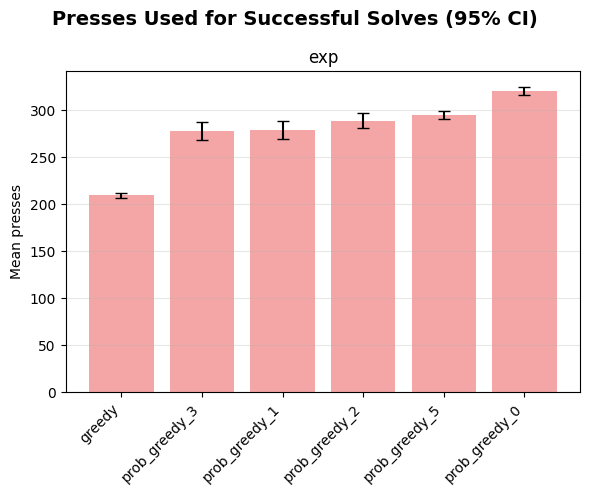

In [39]:
# Mean presses for solved cases - subfigures by kernel
from scipy import stats

rows = []
for (kernel, strategy), g in df.groupby(["kernel", "strategy"]):
    # For each board, compute mean presses across parameter settings where it was solved
    board_mean_presses = g.groupby("board_id")["presses_used"].mean()

    mean_presses = board_mean_presses.mean()
    n = len(board_mean_presses)

    # Standard error and 95% CI using t-distribution at board level
    if n > 1:
        se = stats.sem(board_mean_presses)
        ci = se * stats.t.ppf(0.975, n - 1)
        lo = mean_presses - ci
        hi = mean_presses + ci
    else:
        lo, hi = mean_presses, mean_presses

    rows.append(
        {
            "kernel": kernel,
            "strategy": strategy,
            "mean_presses": mean_presses,
            "lo": lo,
            "hi": hi,
            "n_boards": n,
        }
    )

press_ci = pd.DataFrame(rows).sort_values(["kernel", "strategy"])

kernels = press_ci["kernel"].unique()
fig, axes = plt.subplots(1, len(kernels), figsize=(6 * len(kernels), 5))
if len(kernels) == 1:
    axes = [axes]

for idx, kernel in enumerate(kernels):
    g = press_ci[press_ci["kernel"] == kernel]
    g = g.sort_values("mean_presses", ascending=True)
    x = np.arange(len(g))
    heights = g["mean_presses"]
    lo = g["lo"]
    hi = g["hi"]
    yerr = np.vstack([heights - lo, hi - heights])

    axes[idx].bar(x, heights, color="lightcoral", alpha=0.7)
    axes[idx].errorbar(
        x,
        heights,
        yerr=yerr,
        fmt="none",
        capsize=4,
        color="black",
    )
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(
        g["strategy"].astype(str).tolist(), rotation=45, ha="right"
    )
    axes[idx].set_ylabel("Mean presses")
    axes[idx].set_title(f"{kernel}")
    axes[idx].grid(axis="y", alpha=0.3)

fig.suptitle(
    "Presses Used for Successful Solves (95% CI)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

## 6. Computational Cost Analysis

In [40]:
# Mean time by kernel and strategy - averaged across parameter settings
rows = []
for (kernel, strat), g in board_strat.groupby(
    ["kernel", "strategy"], sort=True
):
    x = g["mean_time_ms"].to_numpy()
    x_action = g["mean_time_per_action_ms"].to_numpy()

    n = len(x)  # Calculate n for this group

    mean_time = x.mean()
    mean_action = x_action.mean()

    se = x.std(ddof=1) / np.sqrt(n)
    se_action = x_action.std(ddof=1) / np.sqrt(n)

    tcrit = stats.t.ppf(0.975, df=n - 1)

    lo, hi = mean_time - tcrit * se, mean_time + tcrit * se
    lo_action, hi_action = (
        mean_action - tcrit * se_action,
        mean_action + tcrit * se_action,
    )
    rows.append(
        {
            "kernel": kernel,
            "strategy": strat,
            "mean_time_ms": mean_time,
            "low_time": lo,
            "high_time": hi,
            "mean_time_action": mean_action,
            "low_action": lo_action,
            "high_action": hi_action,
            "n_runs": len(g),
        }
    )

time_stats = pd.DataFrame(rows).sort_values(["kernel", "mean_time_ms"])
time_stats

,kernel,strategy,mean_time_ms,low_time,high_time,mean_time_action,low_action,high_action,n_runs
0,exp,greedy,3.146399,3.018637,3.274161,0.018046,0.016398,0.019694,100
1,exp,prob_greedy_0,254.005889,248.640272,259.371507,0.833631,0.824932,0.842330,100
4,exp,prob_greedy_3,546.246576,523.905664,568.587488,2.090355,2.067845,2.112866,100
2,exp,prob_greedy_1,551.981521,529.268332,574.694710,2.125703,2.102600,2.148806,100
3,exp,prob_greedy_2,580.068901,562.401971,597.735830,2.095531,2.075599,2.115463,100
5,exp,prob_greedy_5,610.357685,596.491172,624.224198,2.171999,2.147838,2.196159,100


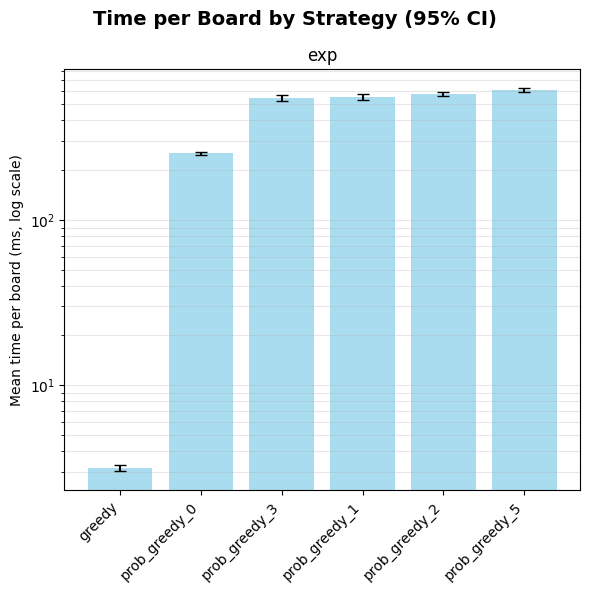

In [41]:
# Plot 1: Mean time per board - subfigures by kernel (with SE-based CI)
from scipy import stats


kernels = time_stats["kernel"].unique()
fig, axes = plt.subplots(1, len(kernels), figsize=(6 * len(kernels), 6))
if len(kernels) == 1:
    axes = [axes]

for idx, kernel in enumerate(kernels):
    g = time_stats[time_stats["kernel"] == kernel]
    g = g.sort_values("mean_time_ms", ascending=True)
    x = np.arange(len(g))
    heights = g["mean_time_ms"]
    lo = g["low_time"]
    hi = g["high_time"]
    yerr = np.vstack([heights - lo, hi - heights])

    axes[idx].bar(x, heights, color="skyblue", alpha=0.7)
    axes[idx].errorbar(
        x,
        heights,
        yerr=yerr,
        fmt="none",
        capsize=4,
        color="black",
    )
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(
        g["strategy"].astype(str).tolist(), rotation=45, ha="right"
    )
    axes[idx].set_ylabel("Mean time per board (ms, log scale)")
    axes[idx].set_title(f"{kernel}")
    axes[idx].grid(axis="y", alpha=0.3, which="both")

    # Use log scale for y-axis
    axes[idx].set_yscale("log")

fig.suptitle(
    "Time per Board by Strategy (95% CI)", fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()